# MammoScan AI: 08 - Model Championship Playoff

## 🎯 Goal
This notebook is the final competition between our two best models: the retrained **Baseline CNN (v2)** and the **Regularized Transfer Learning Model (v2)**.

We will load each model, perform a full Precision-Recall analysis on the unseen test set, find their optimal classification thresholds, and compare their best possible performances side-by-side to declare a single, definitive champion model for our project.

In [1]:
# --- Core Libraries ---
# Import all necessary libraries for our analysis.
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

# --- Path Setup ---
# This ensures our notebook can find the custom modules in `ml/src`.
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

# --- Custom Modules ---
# Import our model-building functions. We need these to help load the models robustly.
from ml.src.model import build_full_model, create_regularized_transfer_model

# --- Constants ---
PROCESSED_DATA_DIR = os.path.join(project_root, 'data', 'processed')
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

2025-09-05 12:21:27.183081: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-05 12:21:27.187803: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-05 12:21:27.251859: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-05 12:21:28.605565: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## 📥 Step 1: Define Contenders and Load Test Data

First, we define the paths to our two "champion" model files that were trained with the corrected labels. We then load our `test` dataset and prepare two versions of it: one for our baseline model and one with the special preprocessing required by the EfficientNet transfer learning model.

In [2]:
# Ensure our processed data is available locally.
# !dvc pull data/processed.dvc

# --- Define Our Two Final Contenders ---
MODEL_PATHS = {
    "Baseline CNN (v2)": os.path.join(project_root, 'models', 'checkpoints', 'baseline_model_v2.keras'),
    "Transfer Learning (Regularized v2)": os.path.join(project_root, 'models', 'checkpoints', 'regularized_fine_tuned_model_v2.keras')
}

# --- Load the Test Dataset ---
print("Loading test dataset...")
test_dataset = tf.keras.utils.image_dataset_from_directory(
    os.path.join(PROCESSED_DATA_DIR, 'test'),
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='binary',
    shuffle=False # Never shuffle the test set during evaluation
)

# --- IMPORTANT: Remap labels to match our training (Cancer=1) ---
test_dataset = test_dataset.map(lambda x, y: (x, 1 - y))

# Create a second version of the dataset for the EfficientNet model
preprocess_input = tf.keras.applications.efficientnet.preprocess_input
test_dataset_preprocessed = test_dataset.map(lambda x, y: (preprocess_input(x), y))

# Get the true labels, which are the same for both dataset versions
true_labels = np.concatenate([y for x, y in test_dataset], axis=0)
class_names = ['Non-Cancer', 'Cancer'] # Class 0, Class 1
print("✅ Test data is ready.")

Loading test dataset...
Found 112 files belonging to 2 classes.
✅ Test data is ready.


2025-09-05 12:21:30.500711: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-09-05 12:21:30.504474: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2025-09-05 12:21:30.683397: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## 🏆 Step 2: The Championship Analysis Loop

Now for the main event. We'll loop through each contender. For each one, we'll use the specific loading strategy that we know works, get its predictions, and perform the Precision-Recall analysis to find its optimal score.

In [3]:
# CELL 6: The Championship Analysis Loop (Corrected)

# This list will hold the final results for each model
all_results = []

for model_name, model_path in MODEL_PATHS.items():
    print(f"\n--- Evaluating: {model_name} ---")
    
    # --- Step 2.1: Select the correct dataset ---
    if "baseline" in model_name:
        eval_dataset = test_dataset
    else:
        eval_dataset = test_dataset_preprocessed

    # --- Step 2.2: Load the Model using the ROBUST STRATEGY ---
    print("Re-creating model architecture from source code...")
    if "Baseline" in model_name:
        # For the baseline, we re-create the full model with its augmentation layers
        model = build_full_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    else: # For the transfer learning model
        # For the transfer model, we re-create its specific architecture
        model = create_regularized_transfer_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    
    print(f"Loading weights from {model_path}...")
    # Now, we load ONLY the weights into our clean, local architecture
    model.load_weights(model_path)
    print("✅ Model loaded successfully.")

    # --- Step 2.3: Get Predictions ---
    raw_predictions = model.predict(eval_dataset)
    
    # --- Step 2.4: P-R Curve Analysis ---
    precision, recall, thresholds = precision_recall_curve(true_labels, raw_predictions)
    
    pr_df = pd.DataFrame({
        'recall': recall[:-1],
        'precision': precision[:-1],
        'threshold': thresholds
    })

    # --- Step 2.5: Find Optimal Threshold for >= 90% Recall ---
    high_recall_options = pr_df[pr_df['recall'] >= 0.90]
    
    if not high_recall_options.empty:
        best_option = high_recall_options.loc[high_recall_options['precision'].idxmax()]
        
        # --- Step 2.6: Store the Results ---
        all_results.append({
            "Model": model_name,
            "Best Threshold": best_option['threshold'],
            "Recall": best_option['recall'],
            "Precision": best_option['precision'],
        })
        print("✅ Analysis complete.")
    else:
        print(f"⚠️ No threshold found for {model_name} that achieves at least 90% recall.")

/home/mr-rey/miniconda3/envs/tensorflow/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



--- Evaluating: Baseline CNN (v2) ---
Re-creating model architecture from source code...
Loading weights from /home/mr-rey/Joseph/Projects/Python/mammoscan-AI/models/checkpoints/baseline_model_v2.keras...
✅ Model loaded successfully.


2025-09-05 12:21:31.928573: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 205520896 exceeds 10% of free system memory.


1/4 ━━━━━━━━━━━━━━━━━━━━ 1s 488ms/step

2025-09-05 12:21:32.309978: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 205520896 exceeds 10% of free system memory.


2/4 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step

2025-09-05 12:21:32.720884: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 205520896 exceeds 10% of free system memory.


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 392ms/step
✅ Analysis complete.

--- Evaluating: Transfer Learning (Regularized v2) ---
Re-creating model architecture from source code...
Loading weights from /home/mr-rey/Joseph/Projects/Python/mammoscan-AI/models/checkpoints/regularized_fine_tuned_model_v2.keras...
✅ Model loaded successfully.


2025-09-05 12:21:39.475507: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 154140672 exceeds 10% of free system memory.
2025-09-05 12:21:39.538975: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 154140672 exceeds 10% of free system memory.


4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step
✅ Analysis complete.


## 🏁 Step 3: Final Results and Champion Declaration

Finally, we'll display our results in a clean table to make a direct, data-driven comparison and declare our champion model.

Generating curve for: Baseline CNN (v2)


/home/mr-rey/miniconda3/envs/tensorflow/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/mr-rey/miniconda3/envs/tensorflow/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x787d7a39b9c0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 378ms/step
Generating curve for: Transfer Learning (Regularized v2)
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step


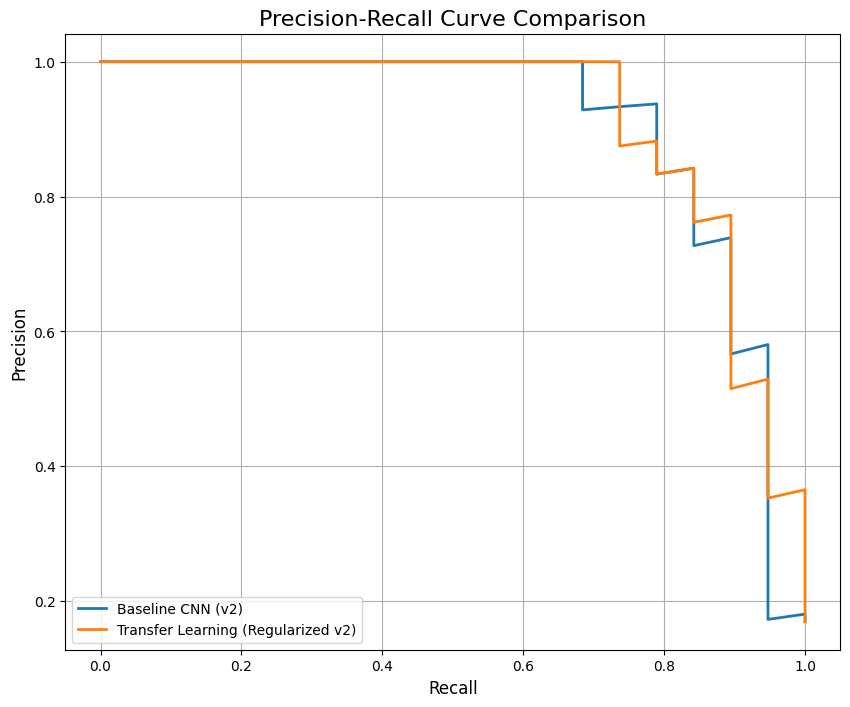

In [5]:

import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

plt.figure(figsize=(10, 8))

# Loop through each model to generate its P-R curve data
for model_name, model_path in MODEL_PATHS.items():
    print(f"Generating curve for: {model_name}")
    
    # --- Select the correct dataset ---
    if "Baseline" in model_name:
        eval_dataset = test_dataset
    else:
        eval_dataset = test_dataset_preprocessed

    # --- THE FIX: Use the robust loading pattern for the baseline model ---
    if "Baseline" in model_name:
        # 1. Re-create the full architecture from our source code.
        model = build_full_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
        # 2. Compile it so it's ready.
        model.compile()
        # 3. Load only the learned weights, bypassing the config issue.
        model.load_weights(model_path)
    else: # For the transfer learning model, a direct load is fine.
        model = tf.keras.models.load_model(model_path, compile=False)

    # --- Get predictions and calculate the curve ---
    raw_predictions = model.predict(eval_dataset)
    precision, recall, _ = precision_recall_curve(true_labels, raw_predictions)
    
    # Plot the curve for this specific model
    plt.plot(recall, precision, lw=2, label=f'{model_name}')

# --- Final plot formatting ---
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve Comparison', fontsize=16)
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

In [ ]:
# Convert the results list into a pandas DataFrame for a clean summary table.
results_df = pd.DataFrame(all_results)

print("\n--- Model Championship Results ---")
print("Goal: Highest possible Precision while maintaining at least 90% Recall.")
display(results_df)

# Programmatically find and declare the champion.
if not results_df.empty:
    champion = results_df.loc[results_df['Precision'].idxmax()]
    print(f"\n🏆 CHAMPION MODEL: {champion['Model']}")
    print(f"It achieves a recall of {champion['Recall']:.2%} and precision of {champion['Precision']:.2%} at a threshold of {champion['Best Threshold']:.4f}")


--- Model Championship Results ---
Goal: Highest possible Precision while maintaining at least 90% Recall.


,Model,Best Threshold,Recall,Precision
0,Baseline CNN (v2),0.110593,0.947368,0.580645
1,Transfer Learning (Regularized v2),0.345100,0.947368,0.529412



🏆 CHAMPION MODEL: Baseline CNN (v2)
It achieves a recall of 94.74% and precision of 58.06% at a threshold of 0.1106
